# Generative Learning—Generating Fashion-MNIST Images with DCGAN

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

CODING_SIZE = 100
BATCH_SIZE = 32
IMAGE_SIZE = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

dataset = datasets.FashionMNIST("./", train=True, download=True, transform=transforms)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

100%|██████████| 26421880/26421880 [00:03<00:00, 7522494.02it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306768.47it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5605050.84it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9239314.07it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw




/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


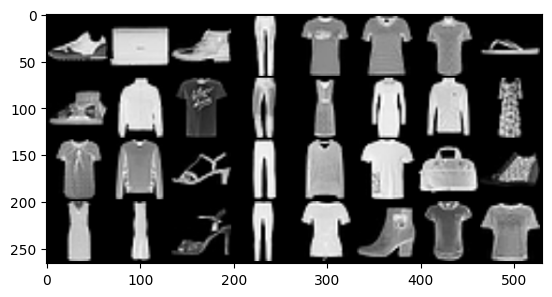

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

data_batch, labels_batch = next(iter(dataloader))
grid_img = make_grid(data_batch, nrow=8)

plt.imshow(grid_img.permute(1, 2, 0))

In [5]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, coding_sz):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(coding_sz, 1024, 4, 1, 0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)


netG = Generator(CODING_SIZE).to(device)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, 4, 1, 0),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.net(input)


netD = Discriminator().to(device)

In [7]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


netG.apply(weight_init)
netD.apply(weight_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [8]:
from torch import optim

criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [9]:
real_labels = torch.full((BATCH_SIZE,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((BATCH_SIZE,), 0.0, dtype=torch.float, device=device)

In [10]:
G_losses = []
D_losses = []
D_real = []
D_fake = []

z = torch.randn((BATCH_SIZE, CODING_SIZE)).view(-1, CODING_SIZE, 1, 1).to(device)
test_out_images = []

In [11]:
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    print(f"Epoch: {epoch}")
    for i, batch in enumerate(dataloader):
        if i % 200 == 0:
            print(f"batch: {i} of {len(dataloader)}")

        # Train Discriminator with an all-real batch.
        netD.zero_grad()
        real_images = batch[0].to(device) * 2.0 - 1.0
        output = netD(real_images).view(-1)
        errD_real = criterion(output, real_labels)
        D_x = output.mean().item()

        # Train Discriminator with an all-fake batch.
        noise = torch.randn((BATCH_SIZE, CODING_SIZE))
        noise = noise.view(-1, 100, 1, 1).to(device)
        fake_images = netG(noise)
        output = netD(fake_images).view(-1)
        errD_fake = criterion(output, fake_labels)
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        errD.backward(retain_graph=True)
        optimizerD.step()

        # Train Generator to generate better fakes.
        netG.zero_grad()
        output = netD(fake_images).view(-1)
        errG = criterion(output, real_labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses for plotting later.
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        D_real.append(D_x)
        D_fake.append(D_G_z2)

    test_images = netG(z).to("cpu").detach()
    test_out_images.append(test_images)

Epoch: 0
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 1
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 2
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 3
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 4
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 180

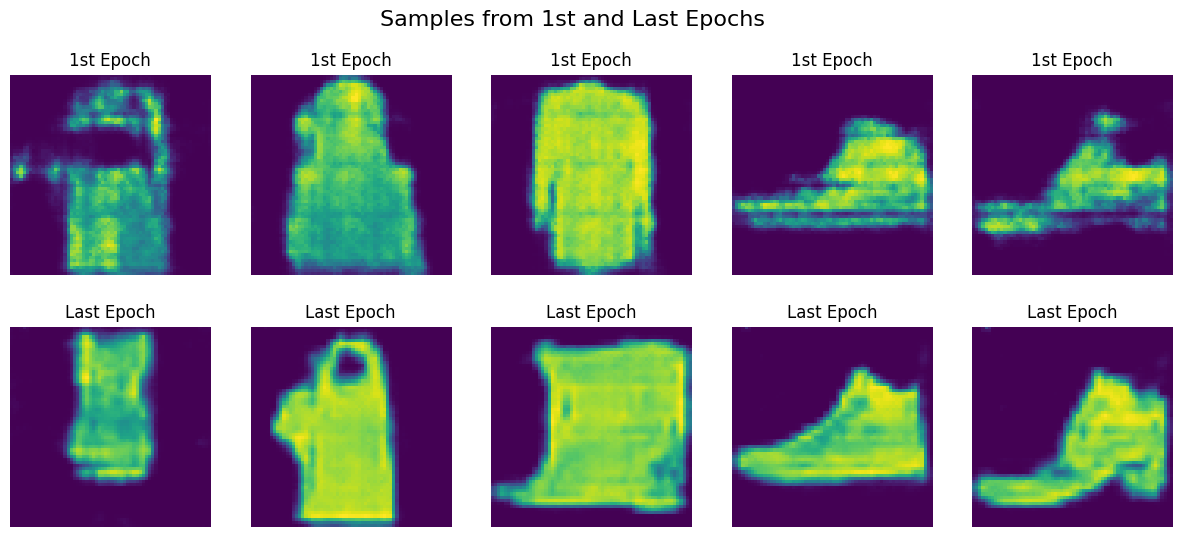

In [12]:
import matplotlib.pyplot as plt


# Plot a sample of images from the 1st and last epochs
def show_epoch_samples(test_out_images):
    # First and last epochs
    first_epoch_images = test_out_images[0]
    last_epoch_images = test_out_images[-1]

    # Number of samples to display (you can adjust this)
    num_samples = min(5, len(first_epoch_images))

    # Plot samples from the 1st epoch
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle("Samples from 1st and Last Epochs", fontsize=16)

    for i in range(num_samples):
        axes[0, i].imshow(
            first_epoch_images[i].permute(1, 2, 0) * 0.5 + 0.5
        )  # Rescale to [0, 1]
        axes[0, i].axis("off")
        axes[0, i].set_title("1st Epoch")

    # Plot samples from the last epoch
    for i in range(num_samples):
        axes[1, i].imshow(
            last_epoch_images[i].permute(1, 2, 0) * 0.5 + 0.5
        )  # Rescale to [0, 1]
        axes[1, i].axis("off")
        axes[1, i].set_title("Last Epoch")

    plt.show()


# Call the function with test_out_images
show_epoch_samples(test_out_images)